In [1]:
#Simple air passengers exponential model
import pandas as pd
from darts import TimeSeries

# Read a pandas DataFrame
df = pd.read_csv('./data/AirPassengers.csv', delimiter=",")

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')

# Set aside the last 36 months as a validation series
train, val = series[:-36], series[-36:]

In [2]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)


Importing plotly failed. Interactive plots will not work.


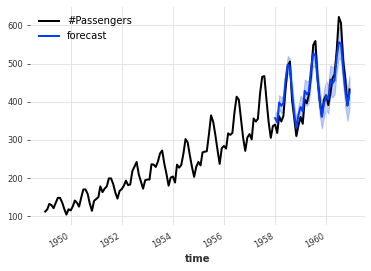

In [3]:
import matplotlib.pyplot as plt

series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [6]:

# Read data:
series = AirPassengersDataset().load()

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp('19590101'))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create month and year covariate series
year_series = datetime_attribute_timeseries(pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000),
                                            attribute='year', one_hot=False)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp('19590101'))

In [7]:
my_model = RNNModel(
    model='LSTM',
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={'lr': 1e-3},
    model_name='Air_RNN',
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True
)

In [8]:
my_model.fit(train_transformed,
             future_covariates=covariates,
             val_series=val_transformed,
             val_future_covariates=covariates,
             verbose=True)

  0%|          | 0/300 [00:00<?, ?it/s]

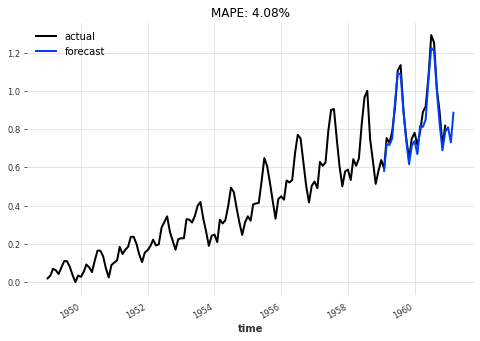

In [9]:
def eval_model(model):
    pred_series = model.predict(n=26, future_covariates=covariates)
    plt.figure(figsize=(8,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();

eval_model(my_model)

loading model_best_290.pth.tar


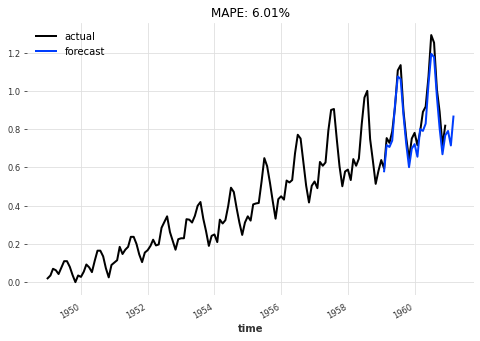

In [10]:
best_model = RNNModel.load_from_checkpoint(model_name='Air_RNN', best=True)
eval_model(best_model)

In [11]:
backtest_series = my_model.historical_forecasts(series_transformed,
                                                future_covariates=covariates,
                                                start=pd.Timestamp('19590101'),
                                                forecast_horizon=6,
                                                retrain=False,
                                                verbose=True)

  0%|          | 0/19 [00:00<?, ?it/s]

MAPE: 2.43%


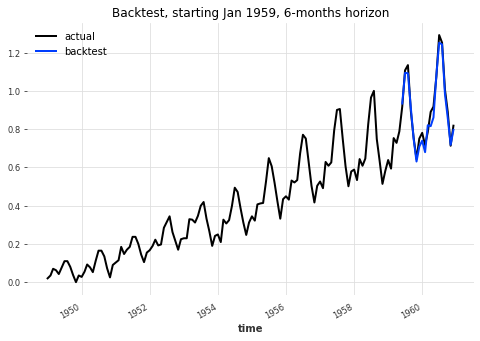

In [12]:

plt.figure(figsize=(8,5))
series_transformed.plot(label='actual')
backtest_series.plot(label='backtest')
plt.legend()
plt.title('Backtest, starting Jan 1959, 6-months horizon');
print('MAPE: {:.2f}%'.format(mape(transformer.inverse_transform(series_transformed),
                                  transformer.inverse_transform(backtest_series))))

In [14]:
#Temporal convolution networks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset

In [15]:
# Read data:
ts = AirPassengersDataset().load()
scaler = Scaler()
ts = scaler.fit_transform(ts)  # scale the whole time series not caring about train/val split...

# We'll use the month as a covariate
month_series = datetime_attribute_timeseries(ts, attribute='month', one_hot=True)
scaler_month = Scaler()
month_series = scaler_month.fit_transform(month_series)

# Create training and validation sets:
train, val = ts.split_after(pd.Timestamp('19580801'))
train_month, val_month = month_series.split_after(pd.Timestamp('19580801'))

In [16]:
model_air = TCNModel(
    input_chunk_length=13,
    output_chunk_length=12,
    n_epochs=500,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0
)

In [17]:
model_air.fit(series=train,
              past_covariates=train_month,
              val_series=val,
              val_past_covariates=val_month,
              verbose=True)

  0%|          | 0/500 [00:00<?, ?it/s]

[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.


  0%|          | 0/39 [00:00<?, ?it/s]

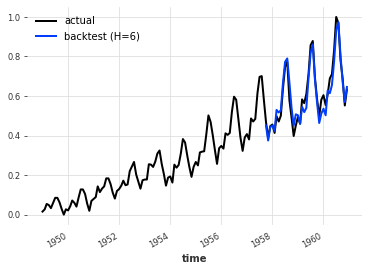

In [18]:
backtest = model_air.historical_forecasts(series=ts,
                                          past_covariates=month_series,
                                          start=0.7,
                                          forecast_horizon=6,
                                          retrain=False,
                                          verbose=True)

ts.plot(label='actual')
backtest.plot(label='backtest (H=6)')
plt.legend();

In [20]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

y = load_airline()
y_train, y_test = temporal_train_test_split(y)
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = ThetaForecaster(sp=12)  # monthly seasonal periodicity
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
mean_absolute_percentage_error(y_test, y_pred)

0.08661467715662399

In [21]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = load_arrow_head(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)
classifier = TimeSeriesForestClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)


0.7924528301886793

<Figure size 360x720 with 0 Axes>

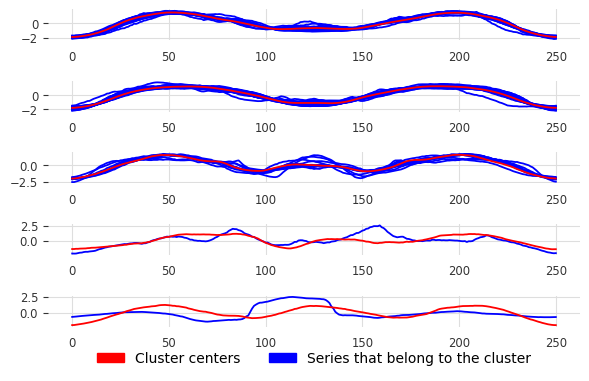

In [22]:
from sklearn.model_selection import train_test_split
from sktime.clustering import TimeSeriesKMeans
from sktime.clustering.evaluation._plot_clustering import plot_cluster_algorithm
from sktime.datasets import load_arrow_head

X, y = load_arrow_head(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

k_means = TimeSeriesKMeans(n_clusters=5, init_algorithm="forgy", metric="dtw")
k_means.fit(X_train)
plot_cluster_algorithm(k_means, X_test, k_means.n_clusters)